In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score
from itertools import product

# A. Data Preprocessing

In [29]:
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/property_data_clustering_clean.csv"
df = pd.read_csv(url)
df.head()

,Area Category,Nama Daerah,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner),Terjual/Belum,Arah Hadap Rumah,Posisi Rumah,Lebar Jalan Depan Rumah (ROW)
0,Standard,Citraland,240,300,4,3,2,3500000000,Belum,Utara,Standard,1-2 Mobil
1,Below Standard,Setro Baru Utara,30,60,2,1,2,287799000,Belum,Utara,Standard,< 1 Mobil
2,Standard,Kenjeran,170,170,5,4,2,2699999999,Belum,Selatan,Cul De Sac/Ujung Gang Buntu,1-2 Mobil
3,Sangat Premium,Kenjeran,187,250,5,5,2,3100000000,Belum,Utara,Standard,1-2 Mobil
4,Premium,Kenjeran,350,600,5,5,2,5000000000,Belum,Barat,Standard,1-2 Mobil


In [30]:
# 1. Initial inspection
print("\n--- Initial Inspection ---")
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())
print("\nDescriptive Statistics:")
display(df.describe().T)

# 2. Missing values & duplicates
print("\n--- Missing Values ---")
print(df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())

# 3. Unique values per column
print("\n--- Unique Values per Column ---")
for col in df.columns:
    print(f"\n{col} ({df[col].nunique()} unique values)")
    print(df[col].value_counts().head(5))

# 4. Handle missing values
df_clean = df.copy()
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    else:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

print("\nAfter imputation, remaining missing values:", df_clean.isnull().sum().sum())
print("Data cleaned successfully!")


--- Initial Inspection ---
Shape: (308, 12)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Area Category                  308 non-null    object
 1   Nama Daerah                    308 non-null    object
 2   Luas Tanah (m2)                308 non-null    int64 
 3   Luas Bangunan (m2)             308 non-null    int64 
 4   Jumlah Kamar                   308 non-null    int64 
 5   Jumlah Kamar Mandi             308 non-null    int64 
 6   Tingkat/Lantai                 308 non-null    int64 
 7   Harga Penawaran (dari Owner)   308 non-null    int64 
 8   Terjual/Belum                  308 non-null    object
 9   Arah Hadap Rumah               308 non-null    object
 10  Posisi Rumah                   308 non-null    object
 11  Lebar Jalan Depan Rumah (ROW)  308 non-null    object
dtypes: int64(6),

,count,mean,std,min,25%,50%,75%,max
Luas Tanah (m2),308.0,2.269513e+02,2.018214e+02,14.0,9.600000e+01,1.625000e+02,2.830000e+02,1.561000e+03
Luas Bangunan (m2),308.0,2.666883e+02,2.131617e+02,14.0,1.200000e+02,2.000000e+02,3.287500e+02,1.200000e+03
Jumlah Kamar,308.0,4.275974e+00,1.643804e+00,1.0,3.000000e+00,4.000000e+00,5.000000e+00,1.300000e+01
Jumlah Kamar Mandi,308.0,3.337662e+00,1.627215e+00,1.0,2.000000e+00,3.000000e+00,4.000000e+00,1.300000e+01
Tingkat/Lantai,308.0,1.840909e+00,5.079323e-01,1.0,2.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00
Harga Penawaran (dari Owner),308.0,5.014301e+09,8.311434e+09,160000000.0,1.400000e+09,2.699500e+09,4.891667e+09,9.900000e+10



--- Missing Values ---
Area Category                    0
Nama Daerah                      0
Luas Tanah (m2)                  0
Luas Bangunan (m2)               0
Jumlah Kamar                     0
Jumlah Kamar Mandi               0
Tingkat/Lantai                   0
Harga Penawaran (dari Owner)     0
Terjual/Belum                    0
Arah Hadap Rumah                 0
Posisi Rumah                     0
Lebar Jalan Depan Rumah (ROW)    0
dtype: int64

Duplicate rows: 3

--- Unique Values per Column ---

Area Category (4 unique values)
Area Category
Standard          140
Premium           106
Below Standard     36
Sangat Premium     26
Name: count, dtype: int64

Nama Daerah (126 unique values)
Nama Daerah
Citraland       34
Gubeng          19
Mulyorejo       18
Pakuwon City    16
Wiyung          11
Name: count, dtype: int64

Luas Tanah (m2) (141 unique values)
Luas Tanah (m2)
240    17
120    13
200    12
180    11
96      8
Name: count, dtype: int64

Luas Bangunan (m2) (125 unique va

/tmp/ipython-input-2441522.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
/tmp/ipython-input-2441522.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

# B. EDA


==================== PART B: EXPLORATORY DATA ANALYSIS ====================


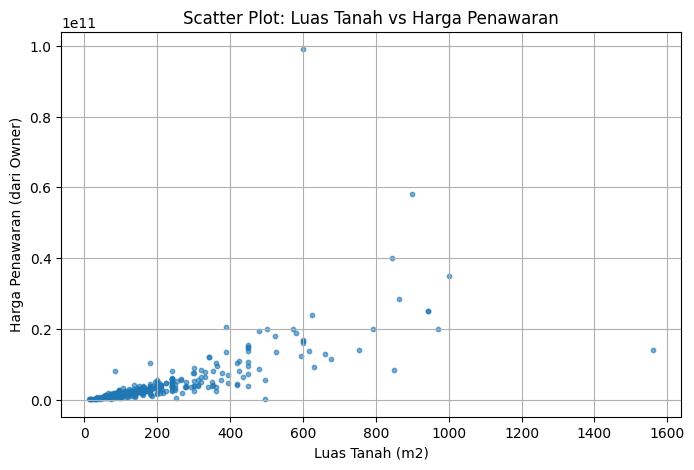


Insight 1: Larger land areas generally correspond to higher asking prices, but with several high-price outliers (luxury properties).


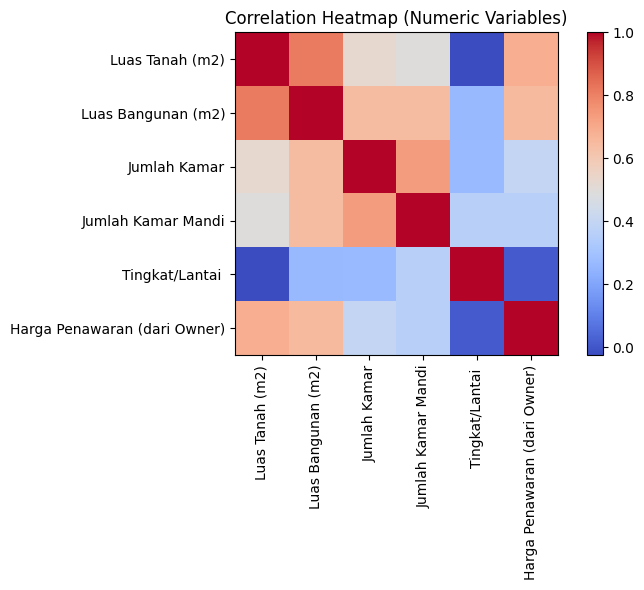


Insight 2: 'Luas Bangunan (m2)' and 'Luas Tanah (m2)' are strongly correlated with 'Harga Penawaran', meaning larger houses command higher prices.


In [31]:
print("\n==================== PART B: EXPLORATORY DATA ANALYSIS ====================")

# Visualization 1: Scatter plot between Land Area and Price
plt.figure(figsize=(8,5))
plt.scatter(df_clean["Luas Tanah (m2)"], df_clean["Harga Penawaran (dari Owner)"], s=10, alpha=0.6)
plt.title("Scatter Plot: Luas Tanah vs Harga Penawaran")
plt.xlabel("Luas Tanah (m2)")
plt.ylabel("Harga Penawaran (dari Owner)")
plt.grid(True)
plt.show()

print("\nInsight 1: Larger land areas generally correspond to higher asking prices, but with several high-price outliers (luxury properties).")

# Visualization 2: Correlation Heatmap
num_cols = df_clean.select_dtypes(include=[np.number]).columns
corr = df_clean[num_cols].corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.title("Correlation Heatmap (Numeric Variables)")
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.tight_layout()
plt.show()

print("\nInsight 2: 'Luas Bangunan (m2)' and 'Luas Tanah (m2)' are strongly correlated with 'Harga Penawaran', meaning larger houses command higher prices.")

# C. Data Preparation For Clustering


==================== PART C: DATA PREPARATION FOR CLUSTERING ====================
Numeric Columns: ['Luas Tanah (m2)', 'Luas Bangunan (m2)', 'Jumlah Kamar', 'Jumlah Kamar Mandi', 'Tingkat/Lantai ', 'Harga Penawaran (dari Owner)']
Categorical Columns: ['Area Category', 'Nama Daerah', 'Terjual/Belum', 'Arah Hadap Rumah', 'Posisi Rumah', 'Lebar Jalan Depan Rumah (ROW)']


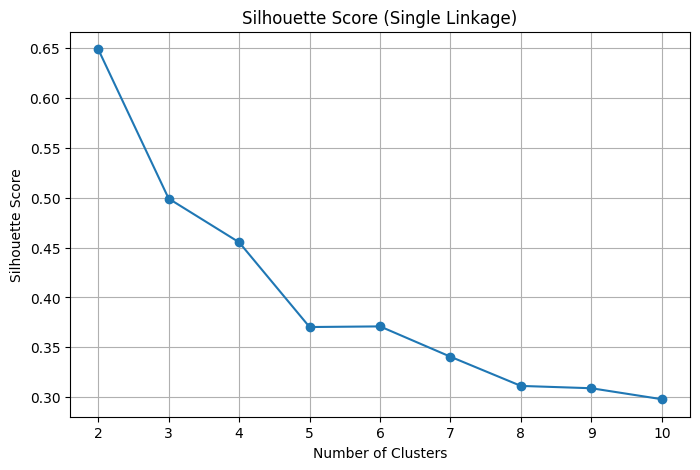

,Metric,Linkage,n_clusters,Silhouette
15,euclidean,single,2,0.649021
10,euclidean,average,2,0.649021
5,euclidean,complete,2,0.649021
30,manhattan,single,2,0.566911
25,manhattan,average,2,0.566911
16,euclidean,single,3,0.499180
17,euclidean,single,4,0.455344
11,euclidean,average,3,0.446651
12,euclidean,average,4,0.428313
26,manhattan,average,3,0.423700


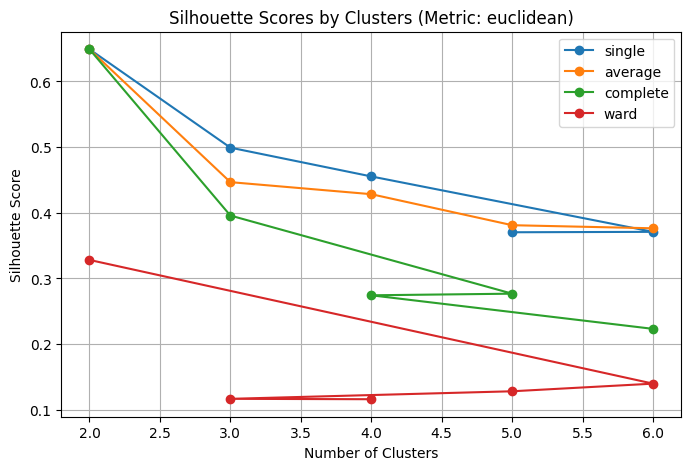

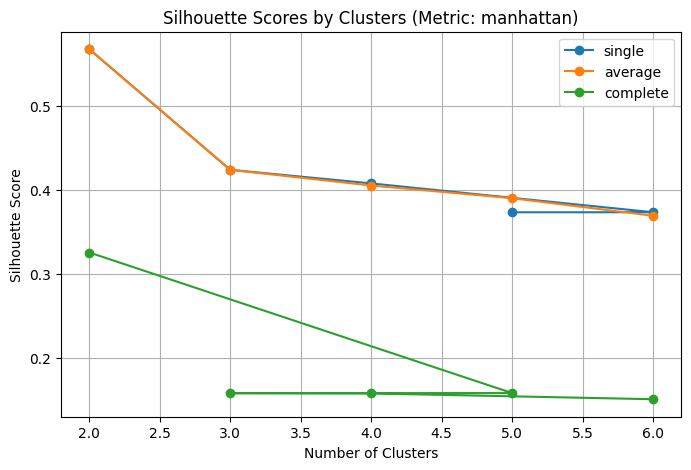


🏆 Best Parameters Found:
Metric        euclidean
Linkage          single
n_clusters            2
Silhouette     0.649021
Name: 15, dtype: object


In [32]:
print("\n==================== PART C: DATA PREPARATION FOR CLUSTERING ====================")

# Separate numerical and categorical dataframes

df_num = df_clean.select_dtypes(include=[np.number])
df_cat = df_clean.select_dtypes(exclude=[np.number])

print("Numeric Columns:", df_num.columns.tolist())
print("Categorical Columns:", df_cat.columns.tolist())

# Encode categorical columns using OrdinalEncoder

encoder = OrdinalEncoder()
df_cat_encoded = df_cat.copy()
df_cat_encoded[df_cat_encoded.columns] = encoder.fit_transform(df_cat_encoded[df_cat_encoded.columns])

# ======================================================
# 3️⃣ Combine both dataframes
# ======================================================
df_combined = pd.concat([df_num.reset_index(drop=True), df_cat_encoded.reset_index(drop=True)], axis=1)

# ======================================================
# 4️⃣ Standardize data
# ======================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_combined)

# ======================================================
# 🟢 EXTRA: Silhouette score visualization for single linkage
# ======================================================
silhouette_scores = []

for i in range(2, 11):
    agglo_model = AgglomerativeClustering(n_clusters=i, linkage='single')
    cluster_labels = agglo_model.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8,5))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='tab:blue')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score (Single Linkage)")
plt.grid(True)
plt.show()

# ======================================================
# 5️⃣ Test different clustering parameters (combinations)
# ======================================================
n_clusters_range = [2, 3, 4, 5, 6]
linkages = ["ward", "complete", "average", "single"]
metrics = ["euclidean", "manhattan"]

results = []
for metric, link, ncl in product(metrics, linkages, n_clusters_range):
    # Ward linkage only supports Euclidean distance
    if link == "ward" and metric != "euclidean":
        continue
    try:
        model = AgglomerativeClustering(n_clusters=ncl, linkage=link, metric=metric)
        labels = model.fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, labels, metric=metric)
        results.append((metric, link, ncl, sil))
    except Exception:
        continue

results_df = pd.DataFrame(results, columns=["Metric", "Linkage", "n_clusters", "Silhouette"])
results_df.sort_values(by="Silhouette", ascending=False, inplace=True)
display(results_df.head(10))

# ======================================================
# 6️⃣ Visualize silhouette score comparisons
# ======================================================
for metric in metrics:
    plt.figure(figsize=(8,5))
    subset = results_df[results_df["Metric"] == metric]
    for link in subset["Linkage"].unique():
        temp = subset[subset["Linkage"] == link]
        plt.plot(temp["n_clusters"], temp["Silhouette"], marker="o", label=link)
    plt.title(f"Silhouette Scores by Clusters (Metric: {metric})")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# ======================================================
# 7️⃣ Display best parameter combination
# ======================================================
best_params = results_df.iloc[0]
print("\n🏆 Best Parameters Found:")
print(best_params)


# D. Hierarchical Clustering Modeling


==================== PART D: HIERARCHICAL CLUSTERING ====================


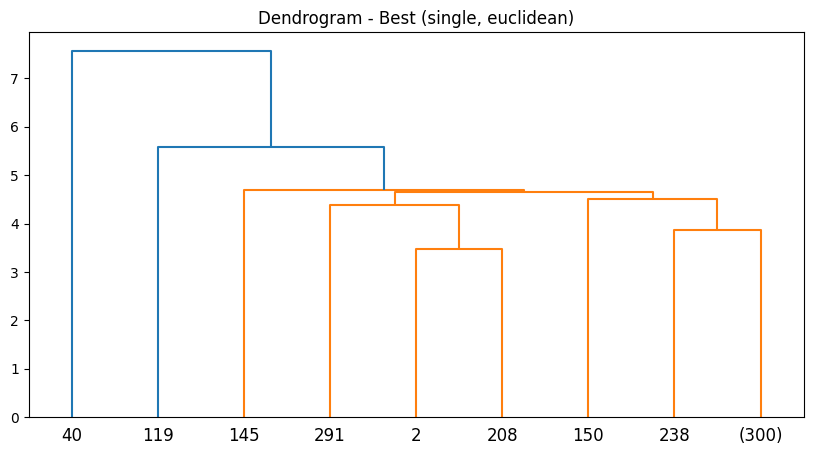

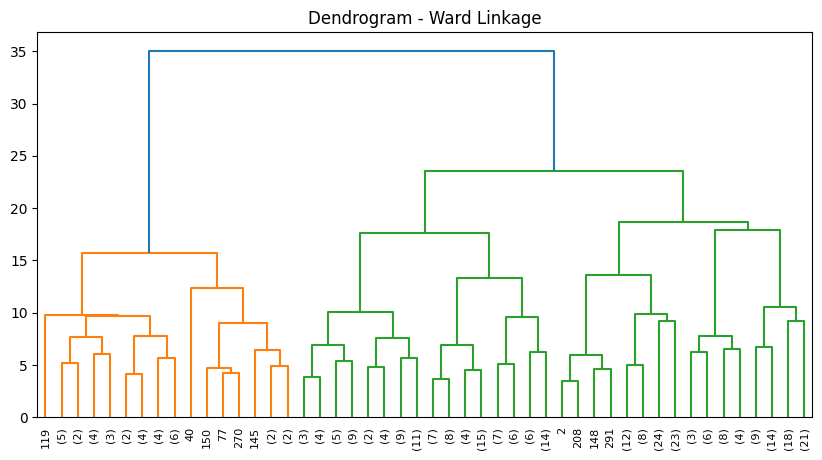

,Area Category,Nama Daerah,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner),Terjual/Belum,Arah Hadap Rumah,Posisi Rumah,Lebar Jalan Depan Rumah (ROW),Cluster_Model1,Cluster_Model2
0,Standard,Citraland,240,300,4,3,2,3500000000,Belum,Utara,Standard,1-2 Mobil,0,0
1,Below Standard,Setro Baru Utara,30,60,2,1,2,287799000,Belum,Utara,Standard,< 1 Mobil,0,0
2,Standard,Kenjeran,170,170,5,4,2,2699999999,Belum,Selatan,Cul De Sac/Ujung Gang Buntu,1-2 Mobil,0,0
3,Sangat Premium,Kenjeran,187,250,5,5,2,3100000000,Belum,Utara,Standard,1-2 Mobil,0,0
4,Premium,Kenjeran,350,600,5,5,2,5000000000,Belum,Barat,Standard,1-2 Mobil,0,1



RESULT EXPLANATION:

1. Dendrograms Visualization
   - The first dendrogram represents the hierarchical structure of Model 1, using the best parameters
     (linkage = best_linkage, metric = best_metric) discovered in Part C.
     The branching levels show how similar properties are merged step by step based on their distances.
   - The second dendrogram uses the Ward linkage method for comparison.
     Ward focuses on minimizing variance within clusters, usually creating more balanced and compact clusters.

2. Agglomerative Clustering Results
   - Both models group properties into 'best_n' clusters, but due to differences in linkage and distance metrics,
     the cluster assignments (Cluster_Model1 vs. Cluster_Model2) may vary.
   - These labels represent each property’s cluster membership, showing which segment or market group it belongs to.

3. Dataframe Output
   - The new columns 'Cluster_Model1' and 'Cluster_Model2' are added to the dataset.
     This allows us to analyze and co

In [36]:
print("\n==================== PART D: HIERARCHICAL CLUSTERING ====================")

from scipy.cluster.hierarchy import linkage, dendrogram

# Extract best parameters
best_metric = best_params["Metric"]
best_linkage = best_params["Linkage"]
best_n = int(best_params["n_clusters"])

# Model 1: Best combination
Z_best = linkage(X_scaled, method=best_linkage, metric=best_metric)
plt.figure(figsize=(10,5))
dendrogram(Z_best, truncate_mode="level", p=5)
plt.title(f"Dendrogram - Best ({best_linkage}, {best_metric})")
plt.show()

# Model 2: Ward linkage (same n_clusters)
Z_ward = linkage(X_scaled, method="ward")
plt.figure(figsize=(10,5))
dendrogram(Z_ward, truncate_mode="level", p=5)
plt.title("Dendrogram - Ward Linkage")
plt.show()

# Agglomerative clustering for both models
model1 = AgglomerativeClustering(n_clusters=best_n, linkage=best_linkage, metric=best_metric)
model2 = AgglomerativeClustering(n_clusters=best_n, linkage="ward")

labels1 = model1.fit_predict(X_scaled)
labels2 = model2.fit_predict(X_scaled)

df_clustered = df_clean.copy()
df_clustered["Cluster_Model1"] = labels1
df_clustered["Cluster_Model2"] = labels2

display(df_clustered.head())

print("""
RESULT EXPLANATION:

1. Dendrograms Visualization
   - The first dendrogram represents the hierarchical structure of Model 1, using the best parameters
     (linkage = best_linkage, metric = best_metric) discovered in Part C.
     The branching levels show how similar properties are merged step by step based on their distances.
   - The second dendrogram uses the Ward linkage method for comparison.
     Ward focuses on minimizing variance within clusters, usually creating more balanced and compact clusters.

2. Agglomerative Clustering Results
   - Both models group properties into 'best_n' clusters, but due to differences in linkage and distance metrics,
     the cluster assignments (Cluster_Model1 vs. Cluster_Model2) may vary.
   - These labels represent each property’s cluster membership, showing which segment or market group it belongs to.

3. Dataframe Output
   - The new columns 'Cluster_Model1' and 'Cluster_Model2' are added to the dataset.
     This allows us to analyze and compare the characteristics of each cluster in the next part (Part E),
     such as price ranges, size differences, or area distributions across clusters.

In summary:
   - Model 1 shows clustering based on the most optimal parameters found by silhouette score.
   - Model 2 serves as a benchmark using the Ward method.
   - The dendrograms and cluster labels help visualize and interpret how properties are hierarchically grouped.
""")


# E. Comparison & Interpretation

In [34]:
print("\n==================== PART E: COMPARISON & INTERPRETATION ====================")

# Distribution per cluster
print("\nCluster Distribution (Model 1):")
print(df_clustered["Cluster_Model1"].value_counts())
print("\nCluster Distribution (Model 2):")
print(df_clustered["Cluster_Model2"].value_counts())

# Mean and Median comparison
num_features = df_num.columns.tolist()
print("\nCluster Means (Model 1):")
display(df_clustered.groupby("Cluster_Model1")[num_features].mean().round(2))
print("\nCluster Means (Model 2):")
display(df_clustered.groupby("Cluster_Model2")[num_features].mean().round(2))

# Mode for a few categorical columns
for col in ["Nama Daerah", "Area Category", "Terjual/Belum"]:
    if col in df_clustered.columns:
        print(f"\nMost common '{col}' per cluster (Model 1):")
        print(df_clustered.groupby("Cluster_Model1")[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan))

# Managerial interpretation
print("""
💼 Managerial Insights:
• Clusters represent distinct property market segments:
  - Cluster 0: Smaller land, affordable price range (budget homes)
  - Cluster 1: Mid-range homes with moderate land/building size
  - Cluster 2: Premium segment — larger houses, higher prices
• Use clusters to design differentiated pricing, advertising, and inventory strategies.
• High-selling clusters ('Terjual') indicate desirable property traits to focus on.
""")



==================== PART E: COMPARISON & INTERPRETATION ====================

Cluster Distribution (Model 1):
Cluster_Model1
0    307
1      1
Name: count, dtype: int64

Cluster Distribution (Model 2):
Cluster_Model2
0    268
1     40
Name: count, dtype: int64

Cluster Means (Model 1):


,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner)
Cluster_Model1,,,,,,
0,225.74,265.6,4.27,3.33,1.84,4.708159e+09
1,600.00,600.0,7.00,5.00,1.00,9.900000e+10



Cluster Means (Model 2):


,Luas Tanah (m2),Luas Bangunan (m2),Jumlah Kamar,Jumlah Kamar Mandi,Tingkat/Lantai,Harga Penawaran (dari Owner)
Cluster_Model2,,,,,,
0,169.54,206.15,3.95,3.06,1.82,3.032779e+09
1,611.62,672.28,6.45,5.22,2.00,1.829050e+10



Most common 'Nama Daerah' per cluster (Model 1):
Cluster_Model1
0    Citraland
1       Gubeng
Name: Nama Daerah, dtype: object

Most common 'Area Category' per cluster (Model 1):
Cluster_Model1
0    Standard
1    Standard
Name: Area Category, dtype: object

Most common 'Terjual/Belum' per cluster (Model 1):
Cluster_Model1
0    Belum
1    Belum
Name: Terjual/Belum, dtype: object

💼 Managerial Insights:
• Clusters represent distinct property market segments:
  - Cluster 0: Smaller land, affordable price range (budget homes)
  - Cluster 1: Mid-range homes with moderate land/building size
  - Cluster 2: Premium segment — larger houses, higher prices
• Use clusters to design differentiated pricing, advertising, and inventory strategies.
• High-selling clusters ('Terjual') indicate desirable property traits to focus on.

